# Notebook 3: Modelo 1 - Regresión Logística
Este notebook entrena y evalúa un modelo de Regresión Logística para la detección de fraude.

Pasos:
1. Carga del dataset preprocesado
2. División en conjuntos de entrenamiento y prueba
3. Búsqueda de hiperparámetros con GridSearchCV
4. Entrenamiento del mejor modelo y evaluación
5. Curva ROC y matriz de confusión
6. Curvas de aprendizaje para detectar sobreajuste o subajuste

## 1. Carga del dataset preprocesado


In [1]:
from google.colab import files
uploaded = files.upload()

Saving dataset_preprocesado.csv to dataset_preprocesado.csv


In [2]:
import pandas as pd
import numpy as np

# Cargamos el dataset procesado
df = pd.read_csv('dataset_preprocesado.csv')
print('Shape del dataset preprocesado:', df.shape)
df.head()

Shape del dataset preprocesado: (924, 32)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Amount.1
0,102572.0,-28.709229,22.057729,0.179011,11.845013,-18.983813,6.474115,-43.557242,-41.044261,-13.320155,...,8.316275,5.466230,0.023854,-1.527145,-0.052266,-5.682338,-0.439134,0.01,1.0,-0.449677
1,10998.0,-0.211134,0.542917,1.526624,-0.445930,-0.163348,-0.274603,0.227532,-0.027924,1.357500,...,0.006634,-0.164857,-0.474453,-0.130723,1.046205,-0.080208,0.001368,39.00,0.0,-0.271375
2,13323.0,-5.454362,8.287421,-12.752811,8.594342,-3.106002,-0.274603,-9.252794,4.245062,-6.329801,...,-0.267172,-0.310804,-1.201685,1.352176,-0.052266,1.574715,0.808725,1.00,1.0,-0.445150
3,55028.0,-0.735658,1.234143,0.731932,1.010075,0.320246,0.859934,0.194436,0.723279,-0.694886,...,0.006634,-0.196655,-0.819615,0.028766,-0.185786,0.297339,0.124236,19.95,0.0,-0.358491
4,84708.0,-10.300820,6.483095,-15.076363,6.554191,-8.880252,-4.471672,-14.900689,0.022167,-4.358441,...,1.041642,-0.682790,0.573544,-1.602389,-0.393521,-0.468893,0.105920,1.00,1.0,-0.445150


## 2. División en conjuntos de entrenamiento y prueba
Separamos las características (X) de la etiqueta (y) y dividimos con un 80%/20%.

In [3]:
from sklearn.model_selection import train_test_split

# Definimos X e y
X = df.drop(columns=['Class'])
y = df['Class']

# División en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print('Tamaño X_train:', X_train.shape)
print('Tamaño X_test:', X_test.shape)

Tamaño X_train: (739, 31)
Tamaño X_test: (185, 31)


## 3. Búsqueda de hiperparámetros con GridSearchCV
Probamos distintos valores de regularización C y penalizaciones l1 y l2.

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Definimos el modelo base
log_base = LogisticRegression(solver='liblinear', max_iter=1000)

# Parametros para GridSearch
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

grid_search = GridSearchCV(
    estimator=log_base,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Ajustamos el GridSearch
grid_search.fit(X_train, y_train)

print('Mejores parámetros encontrados:', grid_search.best_params_)
print('Mejor AUC en validación:', grid_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejores parámetros encontrados: {'C': 1, 'penalty': 'l1'}
Mejor AUC en validación: 0.9791598707185527


## 4. Entrenamiento del mejor modelo y evaluación
Entrenamos el modelo con los mejores hiperparámetros y evaluamos en el conjunto de prueba.

In [5]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Extraemos el mejor estimador
best_log = grid_search.best_estimator_

# Entrenamos en todo el set de entrenamiento
best_log.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
y_pred = best_log.predict(X_test)
y_prob = best_log.predict_proba(X_test)[:, 1]

# Metricas de para evaluación
print('Classification Report:')
print(classification_report(y_test, y_pred))

auc = roc_auc_score(y_test, y_prob)
print(f'AUC en test: {auc:.4f}')

print('Matriz de Confusión:')
cm = confusion_matrix(y_test, y_pred)
print(cm)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91        93
         1.0       0.95      0.86      0.90        92

    accuracy                           0.91       185
   macro avg       0.91      0.91      0.91       185
weighted avg       0.91      0.91      0.91       185

AUC en test: 0.9611
Matriz de Confusión:
[[89  4]
 [13 79]]


## 5. Curva ROC
Graficamos la curva ROC para visualizar el desempeño del modelo.

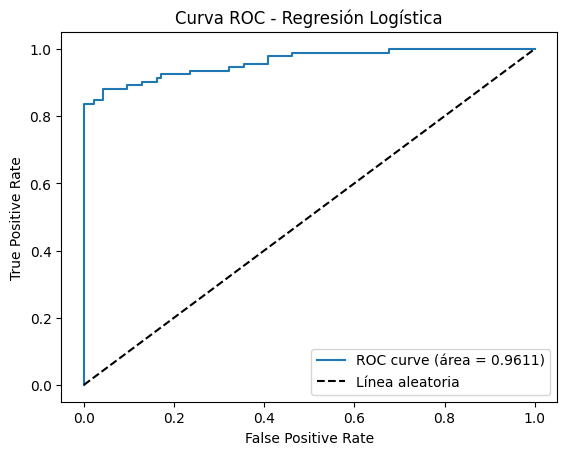

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculamos false positive rate y true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Graficamos
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (área = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Línea aleatoria')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Regresión Logística')
plt.legend(loc='lower right')
plt.show()

## 6. Curvas de aprendizaje
Analizamos cómo varían las puntuaciones de entrenamiento y validación al aumentar el tamaño del conjunto de entrenamiento.

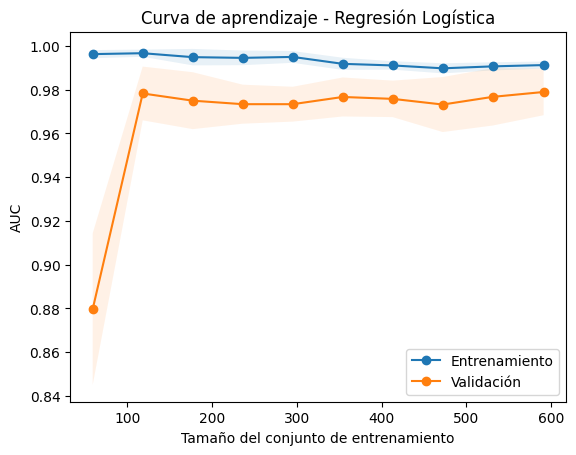

In [7]:
from sklearn.model_selection import learning_curve

# Definimos el modelo con los mejores parámetros
model_for_lc = LogisticRegression(
    solver='liblinear',
    C=grid_search.best_params_['C'],
    penalty=grid_search.best_params_['penalty'],
    max_iter=1000
)

# Calculamos las curvas de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    model_for_lc,
    X_train, y_train,
    cv=5,
    scoring='roc_auc',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

# Promedio y desviación estándar
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Graficamos
plt.figure()
plt.plot(train_sizes, train_mean, 'o-', label='Entrenamiento')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, val_mean, 'o-', label='Validación')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('AUC')
plt.title('Curva de aprendizaje - Regresión Logística')
plt.legend(loc='best')
plt.show()